In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


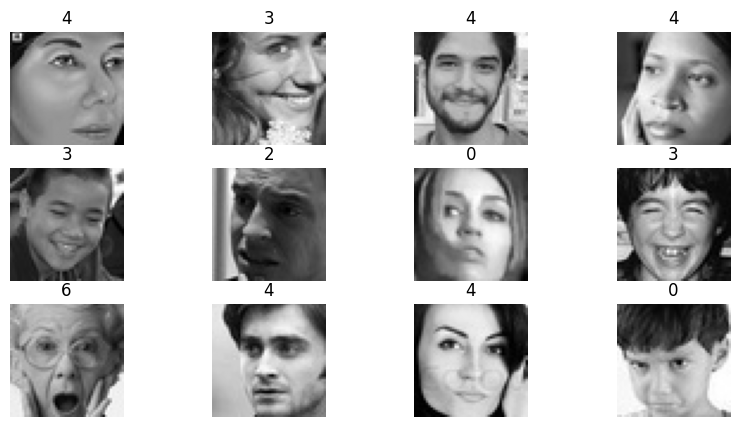

In [19]:
# Paths to dataset (update with your actual path)
val_dir = "/home/namithk/Documents/code/studysense/Data/FER/test"
train_dir = "/home/namithk/Documents/code/studysense/Data/FER/train"

# Preprocessing: normalize [0,255] → [0,1]
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=64,
    shuffle=True
)

val_data = datagen.flow_from_directory(
    val_dir,
    target_size=(48,48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=64,
    shuffle=False
)

# Show class indices (mapping)
print("Class indices:", train_data.class_indices)

# Show sample images with labels
images, labels = next(train_data)
plt.figure(figsize=(10,5))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(images[i].reshape(48,48), cmap="gray")
    plt.title(np.argmax(labels[i]))
    plt.axis("off")
plt.show()


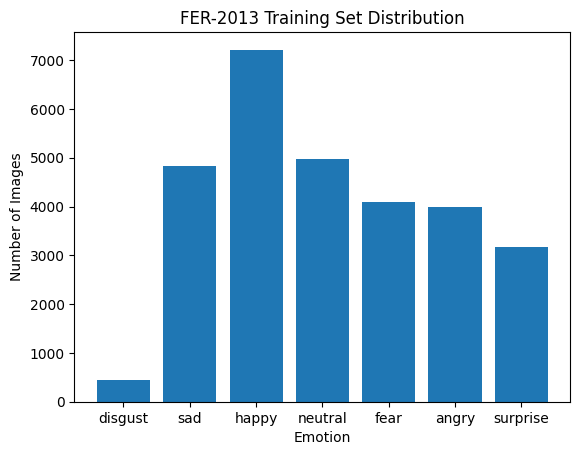

In [20]:
import os

classes = os.listdir(train_dir)
counts = [len(os.listdir(os.path.join(train_dir, c))) for c in classes]

plt.bar(classes, counts)
plt.title("FER-2013 Training Set Distribution")
plt.xlabel("Emotion")
plt.ylabel("Number of Images")
plt.show()


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Base augmentation
base_datagen = ImageDataGenerator(rescale=1./255)

# Augmentation for minority classes
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

# Default datagen for majority classes
mild_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


# Use augmented_datagen for "disgust", mild_datagen for others
train_data = base_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=64,
    shuffle=True
)

val_data = base_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=64,
    shuffle=False
)

class_labels = list(train_data.class_indices.keys())

# Extract integer labels for training samples
all_labels = []
for cls, idx in train_data.class_indices.items():
    folder = os.path.join(train_dir, cls)
    all_labels.extend([idx] * len(os.listdir(folder)))
all_labels = np.array(all_labels)

# Compute weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(zip(np.unique(all_labels), class_weights))

print("Class indices:", train_data.class_indices)
print("Class Weights:", class_weights)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Class Weights: {np.int64(0): np.float64(1.0266046844269623), np.int64(1): np.float64(9.406618610747051), np.int64(2): np.float64(1.0010460615781582), np.int64(3): np.float64(0.5684387684387684), np.int64(4): np.float64(0.8260394187886635), np.int64(5): np.float64(0.8491274770777877), np.int64(6): np.float64(1.293372978330405)}


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_fer_model(input_shape=(48,48,1), num_classes=7):
    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Conv Block 2
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Conv Block 3
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Flatten + Dense Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# -------------------
# Compile Model
# -------------------
model = build_fer_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/home/namithk/miniconda3/envs/studysense/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,094,151 (19.43 MB)

 Trainable params: 5,093,255 (19.43 MB)

 Non-trainable params: 896 (3.50 KB)

In [23]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Train Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    class_weight=class_weights,  # from earlier step
    callbacks=callbacks
)

# Save Model
model.save("fer_cnn_model.h5")


Epoch 1/50


/home/namithk/miniconda3/envs/studysense/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.1860 - loss: 2.1174 - val_accuracy: 0.2190 - val_loss: 2.7451 - learning_rate: 1.0000e-04
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2292 - loss: 1.8804 - val_accuracy: 0.3040 - val_loss: 1.8570 - learning_rate: 1.0000e-04
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2696 - loss: 1.8245 - val_accuracy: 0.3239 - val_loss: 1.7765 - learning_rate: 1.0000e-04
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.3067 - loss: 1.7578 - val_accuracy: 0.3625 - val_loss: 1.6974 - learning_rate: 1.0000e-04
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.3256 - loss: 1.6962 - val_accuracy: 0.3774 - val_loss: 1.6572 - learning_rate: 1.0000e-04
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.3486 - loss: 1.6444 - val_accuracy: 0.3927 - val_loss: 1.6089 - learning_rate: 1.0000e-04
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accurac

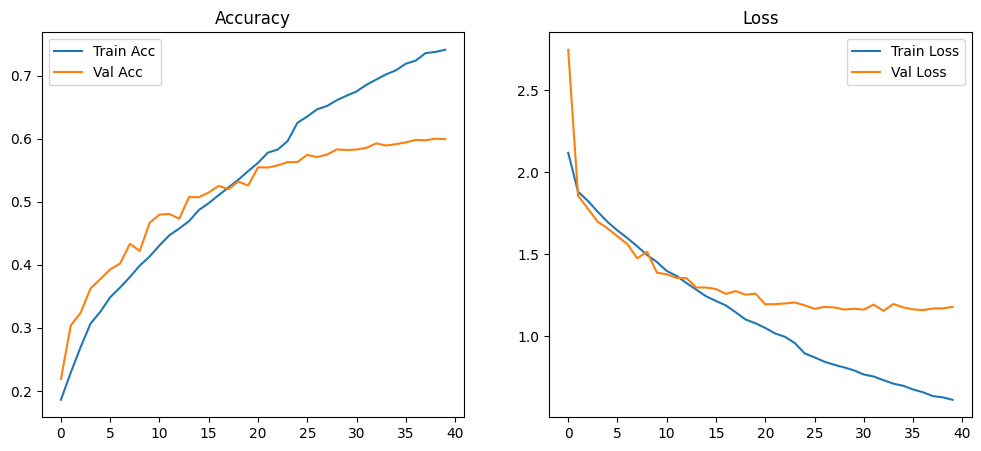

In [25]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

